# OOPAO vs Arseniy for version 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# OOPAO modules
from OOPAO.Source import Source as Source_OOPAO
from OOPAO.Telescope import Telescope as Telescope_OOPAO
from OOPAO.Zernike import Zernike as Zernike_OOPAO



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


**************************************************************************************************************************************************************
NUMPY WARNING: mkl blas not found! Multi-threading may not work as expected.
**************************************************************************************************************************************************************


In [2]:
# Arseniy Local modules
from modules.Telescope import Telescope
from modules.Detector  import Detector
from modules.Source    import Source
from modules.Zernike   import Zernike
from modules.LIFT      import LIFT

# Local auxillary modules
from tools.misc import draw_PSF_difference
from tools.misc import mask_circle
from tools.misc import binning

CuPy is not found, using NumPy backend...
CuPy is not installed, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...


In [3]:
from Rafael_tools.Rafael_tools import make_3_plot_graph

CuPy is not found, using NumPy backend...


## OPD generation

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             10               [m]        
    Resolution           200             [pixels]     
    Pixel Size           0.05              [m]        
     Surface             79.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      31428            [pixels]     
  Field of View           0              [arcsec]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Source Wavelength Zenith  Azimuth   Altitude Magnitude    Flux   
           [m]    [arcsec]  [deg]      [m]              [phot/m2/s]
-------------------------------------------------------------------
  NGS   1.654e-06    0        0        inf       18.0     188.6   
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

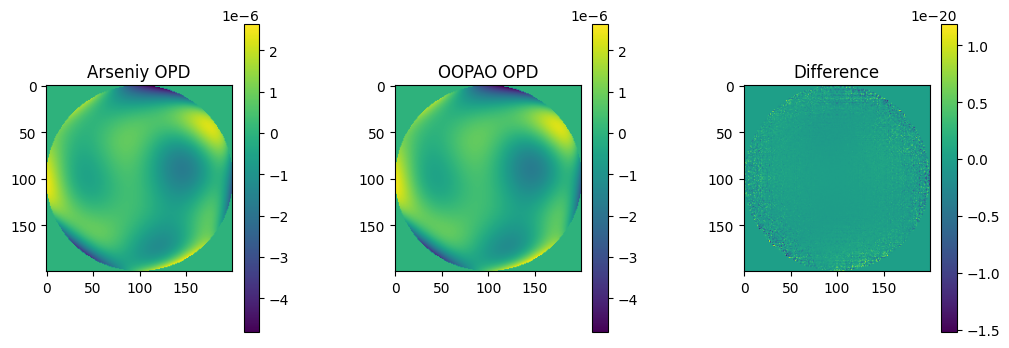

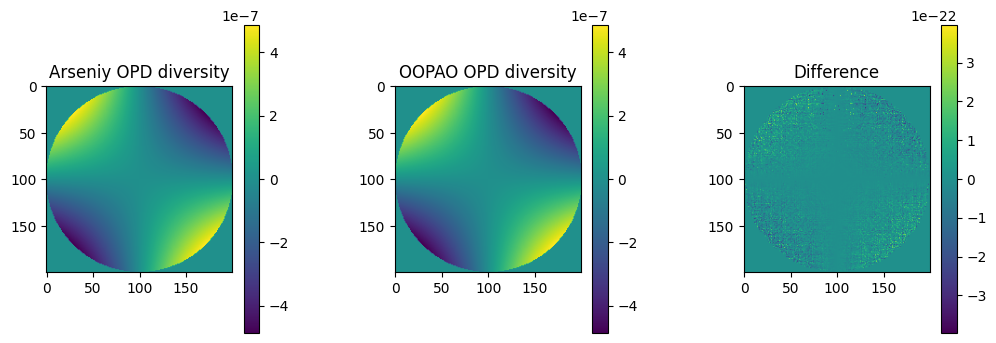

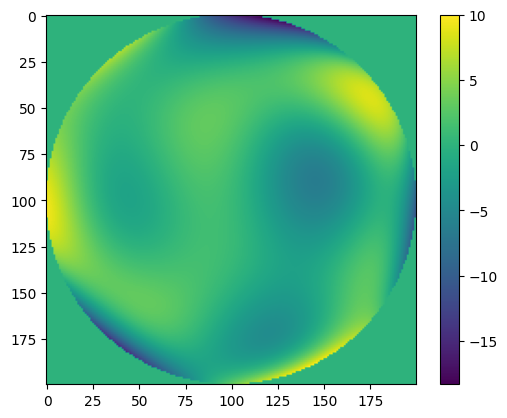

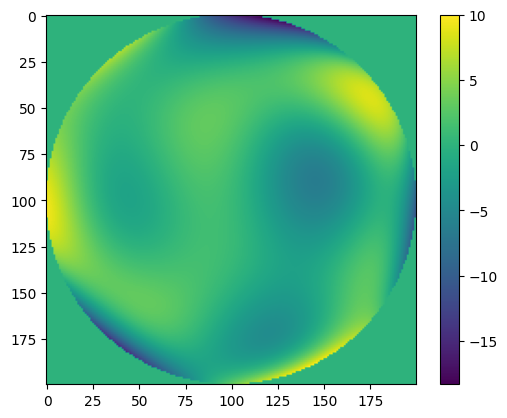

In [4]:
# with OOPAO

# create the Telescope object
tel_OOPAO = Telescope_OOPAO(resolution = 200, diameter = 10, centralObstruction = 0, samplingTime=0.1)

src_OOPAO = Source_OOPAO(optBand = 'H', magnitude = 18.0) 
src_OOPAO*tel_OOPAO

##%% -----------------------     ZERNIKE    ----------------------------------
nModes = 100                # number of zernike to compute

#create a zernike object
Z_OOPAO = Zernike_OOPAO(telObject = tel_OOPAO, J = nModes)

# compute the zernike polynomials associated to the telescope tel
Z_OOPAO.computeZernike(tel_OOPAO)

amp = np.zeros(nModes)

max_abs = 300e-9
number_modes = 25
amp[:number_modes] = np.random.uniform(-max_abs, max_abs, number_modes)

tel_OOPAO.OPD = np.squeeze(Z_OOPAO.modesFullRes@amp)

# With Atseniy code
D = 10.0 # [m]
resolution = 200 # telescope resolution (pupil sampling)

pixel_size = 18e-6 # [m]
ang_pixel = 50 # [mas]
f = pixel_size / ang_pixel * 206264806.71915 # [m]

# Let's imagine we have DITs (detector integration times) of 10 frames with a total of 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.1 # [s]
num_samples = 10

# If the number of pixels in image is odd, the code will automatically center generated PSFs it to one pixel in the middle
tel = Telescope(img_resolution        = 7,  # img_resolution - Sampling of the telescope's PSF
                    pupil             = mask_circle(resolution, resolution/2, center=(0,0), centered=True),
                    diameter          = D,
                    focalLength       = f,
                    pupilReflectivity = 1.0,
                    gpu_flag          = False)

ngs = Source([('H', 10.0)]) # Initialize a target of H_mag=10
ngs * tel # attach the source to the telescope

det = Detector(pixel_size     = pixel_size,
                sampling_time = sampling_time,
                samples       = num_samples,
                RON           = 0.0, # used to generate PSF or the synthetic R_n [photons]
                QE            = 0.7) # not used

det.object = None
det * tel
ngs = Source([('H', 18.0)]) # Initialize a target of H_mag=10
ngs * tel # attach the source to the telescope

print('Source spectrum')
print(ngs.spectrum)
print(tel.src.spectrum)

# Initialize modal basis
Z_basis = Zernike(modes_num = 100)
Z_basis.computeZernike(tel)

tel.src.OPD = Z_basis.wavefrontFromModes(tel,amp)

OPD_difference = tel.src.OPD - tel_OOPAO.OPD

make_3_plot_graph(tel.src.OPD,"Arseniy OPD",tel_OOPAO.OPD,"OOPAO OPD",OPD_difference,"Difference")

diversity_shift = 200e-9 #[m]
OPD_diversity = Z_basis.Mode(3)*diversity_shift

amp_aux = np.zeros(nModes)
amp_aux[3] = 200e-9 #[m]

OPD_diversity_OOPAO = np.squeeze(Z_OOPAO.modesFullRes@amp_aux)

OPD_diversity_dif = OPD_diversity - OPD_diversity_OOPAO

make_3_plot_graph(OPD_diversity,"Arseniy OPD diversity",OPD_diversity_OOPAO,"OOPAO OPD diversity",OPD_diversity_dif,"Difference")

plt.imshow(tel_OOPAO.src.phase)
plt.colorbar()
plt.show()

plt.imshow(tel_OOPAO.OPD*2*np.pi/tel_OOPAO.src.wavelength)
plt.colorbar()
plt.show()

## Wavelength and source parameters

In [5]:
print("wavelength")
print(tel_OOPAO.src.wavelength) # m
print("bandwith")
print(tel_OOPAO.src.bandwidth) # m
print("flux")
print(tel_OOPAO.src.nPhoton)  # number of photon per m2 per s

print(ngs.spectrum)

wavelength
1.654e-06
bandwith
2.9e-07
flux
188.60138014353592
[{'wavelength': 1.654e-06, 'bandwidth': 2.9e-07, 'flux': 188.60138014353592}]


## Amplitude

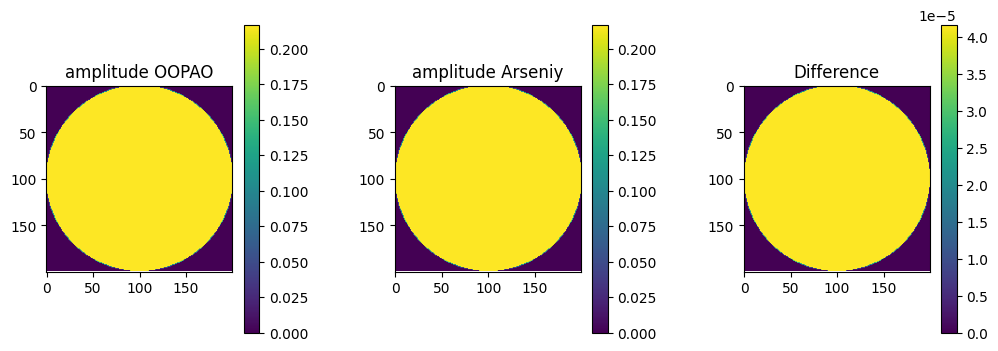

In [6]:
amplitude_OOPAO = np.sqrt(tel_OOPAO.src.fluxMap)
amplitude_Arseniy = np.sqrt(tel.flux(ngs.spectrum[0]['flux'], 0.1)*tel.pupil)

amplitude_dif = amplitude_OOPAO - amplitude_Arseniy

make_3_plot_graph(amplitude_OOPAO,"amplitude OOPAO",amplitude_Arseniy,"amplitude Arseniy",\
                  amplitude_dif,"Difference")

# ModeBasis FullRes

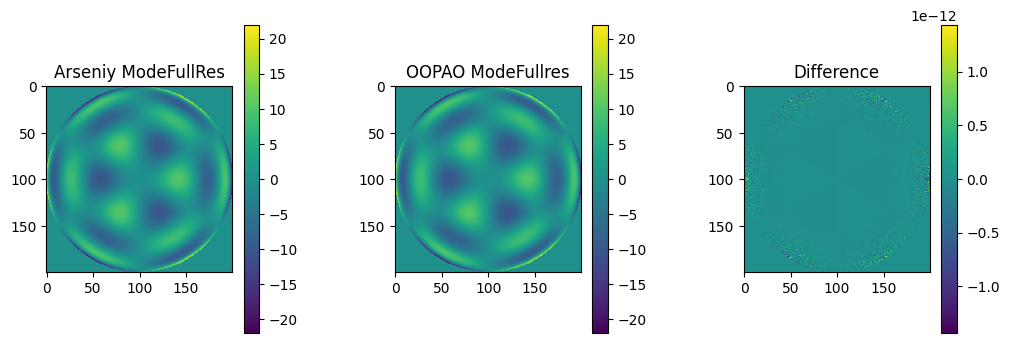

In [7]:
a = Z_basis.modesFullRes[:,:,47]*5

# plt.imshow(a)
# plt.colorbar()
# plt.show()

b = np.squeeze(Z_OOPAO.modesFullRes[:,:,47])*5

# plt.imshow(b)
# plt.colorbar()
# plt.show()

make_3_plot_graph(a,"Arseniy ModeFullRes",b,"OOPAO ModeFullres",\
                  a-b,"Difference")

## Field propagation and PSF computation

In [9]:
try:
    import cupy as cp
    global_gpu_flag = True
except ImportError or ModuleNotFoundError:
    print('CuPy is not found, using NumPy backend...')
    cp = np
    global_gpu_flag = False

from modules.Detector_Rafael  import Detector_Rafael

det_pixel_size = 18e-6 # [m]
det_ang_pixel = 50 # [mas]
f = det_pixel_size / det_ang_pixel * 206264806.71915 # [m]

det_1 = Detector_Rafael(tel=tel_OOPAO, pixel_size=det_pixel_size, ang_pixel=det_ang_pixel, img_resolution = 7, samples=1, RON=0, QE=1)

def PropagateField_OOPAO(tel, det, amplitude, phase, wavelength, return_intensity, oversampling=1):
    
    xp = np

    # img_resolution = 45

    zeroPaddingFactor = det.f / det.pixel_size * wavelength / tel.D
    resolution = tel.pupil.shape[0]
    
    if oversampling is not None: oversampling = oversampling

    if det.img_resolution > zeroPaddingFactor*resolution:
        print('Error: image has too many pixels for this pupil sampling. Try using a pupil mask with more pixels')
        return None

    # If PSF is undersampled apply the integer oversampling
    if zeroPaddingFactor * oversampling < 2:
        oversampling = (np.ceil(2.0/zeroPaddingFactor)).astype('int')
    
    # This is to ensure that PSF will be binned properly if number of pixels is odd
    if oversampling % 2 != det.img_resolution % 2:
        oversampling += 1

    img_size = np.ceil(det.img_resolution*oversampling).astype('int')
    N = np.fix(zeroPaddingFactor * oversampling * resolution).astype('int')
    pad_width = np.ceil((N-resolution)/2).astype('int')

    if not hasattr(amplitude, 'device'): amplitude = xp.array(amplitude, dtype=cp.float32)
    if not hasattr(phase, 'device'):     phase     = xp.array(phase, dtype=cp.complex64)
    
    #supportPadded = cp.pad(amplitude * cp.exp(1j*phase), pad_width=pad_width, constant_values=0)
    supportPadded = xp.pad(amplitude * xp.exp(1j*phase), pad_width=((pad_width,pad_width),(pad_width,pad_width)), constant_values=0)
    N = supportPadded.shape[0] # make sure the number of pxels is correct after the padding

    # PSF computation
    [xx,yy] = xp.meshgrid( xp.linspace(0,N-1,N), xp.linspace(0,N-1,N), copy=False )    
    center_aligner = xp.exp(-1j*xp.pi/N * (xx+yy) * (1-det.img_resolution%2)).astype(xp.complex64)
    #                                                        ^--- this is to account odd/even number of pixels
    # Propagate with Fourier shifting
    EMF = xp.fft.fftshift(1/N * xp.fft.fft2(xp.fft.ifftshift(supportPadded*center_aligner)))

    # Again, this is to properly crop a PSF with the odd/even number of pixels
    if N % 2 == img_size % 2:
        shift_pix = 0
    else:
        if N % 2 == 0: shift_pix = 1
        else: shift_pix = -1

    # Support only rectangular PSFs
    ids = xp.array([np.ceil(N/2) - img_size//2+(1-N%2)-1, np.ceil(N/2) + img_size//2+shift_pix]).astype(xp.int32)
    EMF = EMF[ids[0]:ids[1], ids[0]:ids[1]]

    if return_intensity:
        return binning(xp.abs(EMF)**2, oversampling)

    return EMF # in this case, raw electromagnetic field is returned. It can't be simply binned

CuPy is not found, using NumPy backend...


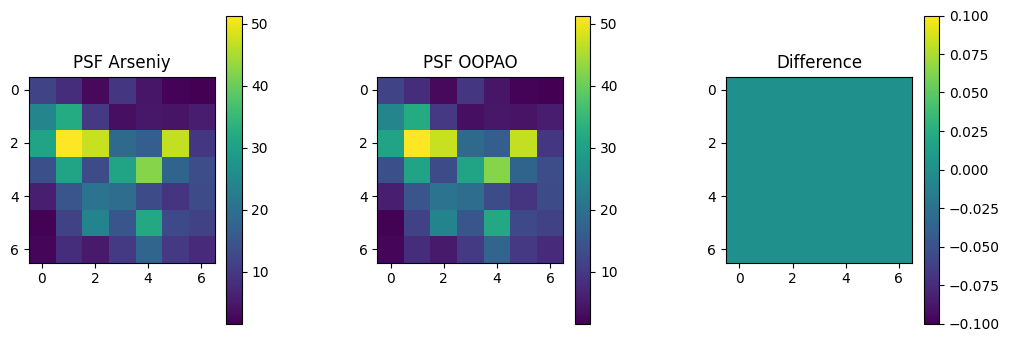

In [10]:
PSF_Arseniy = tel.PropagateField(amplitude=np.sqrt(tel_OOPAO.src.fluxMap), phase=tel_OOPAO.src.phase, wavelength=tel_OOPAO.src.wavelength\
                                 , return_intensity=True, oversampling=None)

PSF_OOPAO = PropagateField_OOPAO(tel_OOPAO, det_1, amplitude=np.sqrt(tel_OOPAO.src.fluxMap), phase=tel_OOPAO.src.phase, \
                                 wavelength=tel_OOPAO.src.wavelength, return_intensity = True, oversampling=1)

make_3_plot_graph(PSF_Arseniy,"PSF Arseniy",PSF_OOPAO,"PSF OOPAO",PSF_Arseniy-PSF_OOPAO,"Difference")

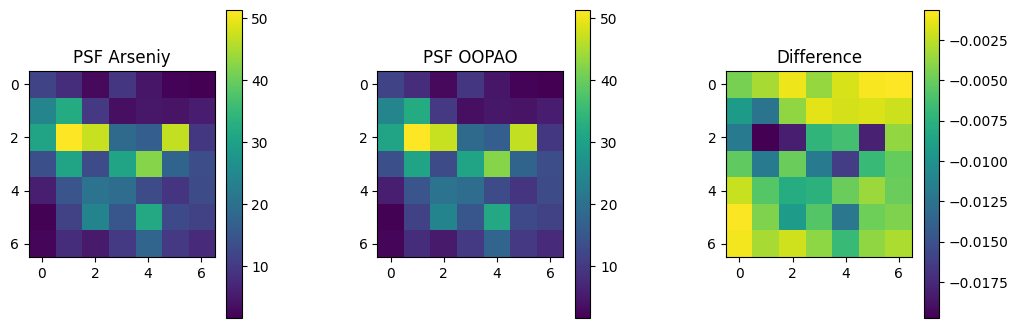

In [11]:
PSF_Arseniy = tel.ComputePSF()

make_3_plot_graph(PSF_Arseniy,"PSF Arseniy",PSF_OOPAO,"PSF OOPAO",PSF_Arseniy-PSF_OOPAO,"Difference")